# Boosting

This notebook implements boosting, which is an **ensemble method** that combines several weak models to make a final prediction. Specifically, each model will attempt to correct the mistakes made by the previous models.

Unlike bagging, boosting does not involve sampling the data randomly or training models independently. Instead, boosting adjusts the weights of misclassified data points to focus on the instances that are difficult to predict. Furthermore, boosting is primarily used to reduce model bias. This is thanks to the sequential training of weak models allowing the model to gradually refine its ability to capture complex patterns in the data.

The scikit-learn library has two boosting methods that I will be exploring: **AdaBoost** and **Gradient Boosting**. The main difference between AdaBoost and Gradient Boosting is the way in which the weights of the examples are updated. In AdaBoost, the weights of the misclassified examples are increased after each round of training, whereas in gradient boosting, the weights are adjusted based on the gradient of the loss function with respect to the model parameters.

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boundaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Import functions to help with training/testing endeavors and evaluate performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Import functions to perform boosting, with relevant models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
#from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import GradientBoostingRegressor

## The Data

The model will be trained using the [Hawks](https://github.com/kary5678/INDE-577/blob/main/Data/hawks.csv) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


Because AdaBoost is primarily designed for binary classification problems, and also since I'm going to use algorithms for binary classification such as logistic regression as one of my learners, I am going to set up the species variable into a binary response. 

Furthermore, because I'm curious what the decision regions look like, I'm just going to just focus on the two predictors I've been focusing on throughout this repository.

In [3]:
X = hawks[["Wing", "Tail"]].to_numpy()
# Convert each entry of y with RT (red-tailed) to -1 and otherwise 1
hawks["Species_binary"] = [1 if x == "RT" else -1 for x in hawks.Species]
y = hawks["Species_binary"].to_numpy()

Finally, the processed data is randomly split into a training and testing set using the traditional 80-20 rule of the Pareto Principle. The parameter `random_state=1` is used to ensure that we get the same observations in the training/testing set as in the Hawks exploratory analysis notebook [here](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb). We know from the plots in `hawks_analysis.ipynb` that the split using this `random_state` produces a training set that is a good representation for the data being tested (and vice versa).

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

### Helpful functions to visualize results for comparison

In [5]:
def compare_RT_confusion_matrix(y_actual, y_pred1, y_pred2, clf1_title = "", clf2_title = ""):
    """
    Plots the confusion matrix given the actual and predicted values for two models side-by-side
    to easily compare and view accurate classifications and type I/II errors
    """             
    classes = [1, -1] # want to invert the order of the classes in outputted matrix
    # Obtain confusion matrices for each model
    cf_matrix1 = confusion_matrix(y_actual, y_pred1, labels = [1, -1])
    cf_matrix2 = confusion_matrix(y_actual, y_pred2, labels = [1, -1])

    # View the confusion matrix using the seaborn package
    fig, axes = plt.subplots(1, 2, figsize =(13, 5))
    fig.suptitle("Hawk Species Classification Confusion Matrix", fontsize = 15)
    fig = sns.heatmap(cf_matrix1, annot = True, cmap = 'Blues', fmt = 'g', ax = axes[0])
    axes[0].set_title(clf1_title, fontsize = 13)
    axes[0].set_xlabel('\nPredicted Values', fontsize = 12)
    axes[0].set_ylabel('Actual Values ', fontsize = 12)
    axes[0].xaxis.set_ticklabels(["RT", "Not RT"], fontsize = 10)
    axes[0].yaxis.set_ticklabels(["RT", "Not RT"], fontsize = 10)

    # View the 2nd classifier's confusion matrix
    fig = sns.heatmap(cf_matrix2, annot = True, cmap = 'Blues', fmt = 'g', ax = axes[1])
    axes[1].set_title(clf2_title, fontsize = 13)
    axes[1].set_xlabel('\nPredicted Values', fontsize = 12)
    axes[1].set_ylabel('Actual Values ', fontsize = 12)
    axes[1].xaxis.set_ticklabels(["RT", "Not RT"], fontsize = 10)
    axes[1].yaxis.set_ticklabels(["RT", "Not RT"], fontsize = 10)

In [6]:
def compare_decision_regions(X, y, clf1, clf2, clf1_title = "", clf2_title = ""):
    """
    Plot the decision regions for the original learner and the boosted model side by side for comparison.
    For the purposes of this notebook, the full dataset will be used. In practice, it would be good to
    plot either the training or the testing subset specifically in order to see how the models perform.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle("Decision Regions for Red-tailed Hawks vs. Not (Full Dataset)", fontsize = 16)
    # Produce a scatterplot of tail vs. wing length, color-coded by hawk species, for the first model
    fig = plot_decision_regions(X, y, clf = clf1, ax = axes[0])
    axes[0].set_xlabel("Wing length [mm]", fontsize = 13)
    axes[0].set_ylabel("Tail length [mm]", fontsize = 13)
    axes[0].set_title(clf1_title, fontsize = 14)
    axes[0].legend(fontsize = 13, loc = "upper left")

    # Produce a scatterplot of tail vs. wing length, color-coded by hawk species, for the second model
    fig = plot_decision_regions(X, y, clf = clf2, ax = axes[1])
    axes[1].set_xlabel("Wing length [mm]", fontsize = 13)
    axes[1].set_ylabel("Tail length [mm]", fontsize = 13)
    axes[1].set_title(clf2_title, fontsize = 14)
    axes[1].legend(fontsize = 13, loc = "upper left")

## 1. AdaBoost

Again, AdaBoost is primarily designed for binary classification problems. After each round of training, each of the misclassified training instances are given a relative weight. The next round is then trained on the dataset accounting for these relative weights. These misclassified data points are "boosted" to signal difficulty in classification. I will implement AdaBoost on a few different learners.

### 1A. Logistic Regression

Logistic regression is often used as a weak learner in boosting because it is computationally efficient and has low complexity.

In [7]:
log_model = LogisticRegression(random_state = 42)
log_model.fit(X_train, y_train)
print("Training accuracy:", log_model.score(X_train, y_train))
print("Testing accuracy:", log_model.score(X_test, y_test))

Training accuracy: 0.9845505617977528
Testing accuracy: 0.9888268156424581


In [8]:
ada_log = AdaBoostClassifier(log_model, n_estimators = 10, algorithm = "SAMME.R", learning_rate = 0.5)
ada_log.fit(X_train, y_train)
print("Training accuracy:", ada_log.score(X_train, y_train))
print("Testing accuracy:", ada_log.score(X_test, y_test))

ada_log_y_pred = ada_log.predict(X_test)
print(f"\nLogistic Regression AdaBoost Classification Report")
print(classification_report(y_test,ada_log_y_pred), "\n")

Training accuracy: 0.952247191011236
Testing accuracy: 0.9608938547486033

Logistic Regression AdaBoost Classification Report
              precision    recall  f1-score   support

          -1       1.00      0.90      0.95        73
           1       0.94      1.00      0.97       106

    accuracy                           0.96       179
   macro avg       0.97      0.95      0.96       179
weighted avg       0.96      0.96      0.96       179
 



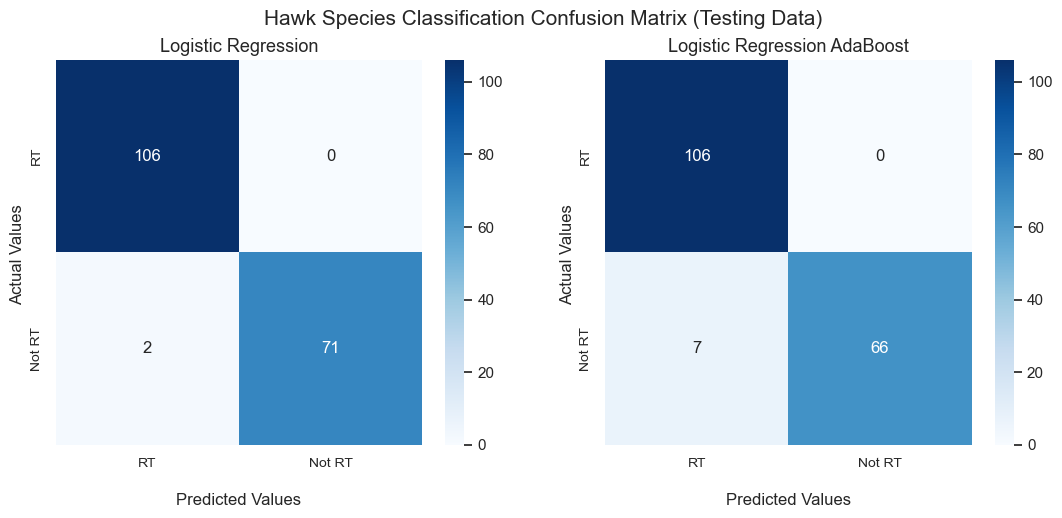

In [9]:
compare_RT_confusion_matrix(y_test, log_model.predict(X_test), ada_log_y_pred,
                            clf1_title = "Logistic Regression",
                            clf2_title = "Logistic Regression AdaBoost")
plt.suptitle("Hawk Species Classification Confusion Matrix (Testing Data)", fontsize = 15)
plt.show()

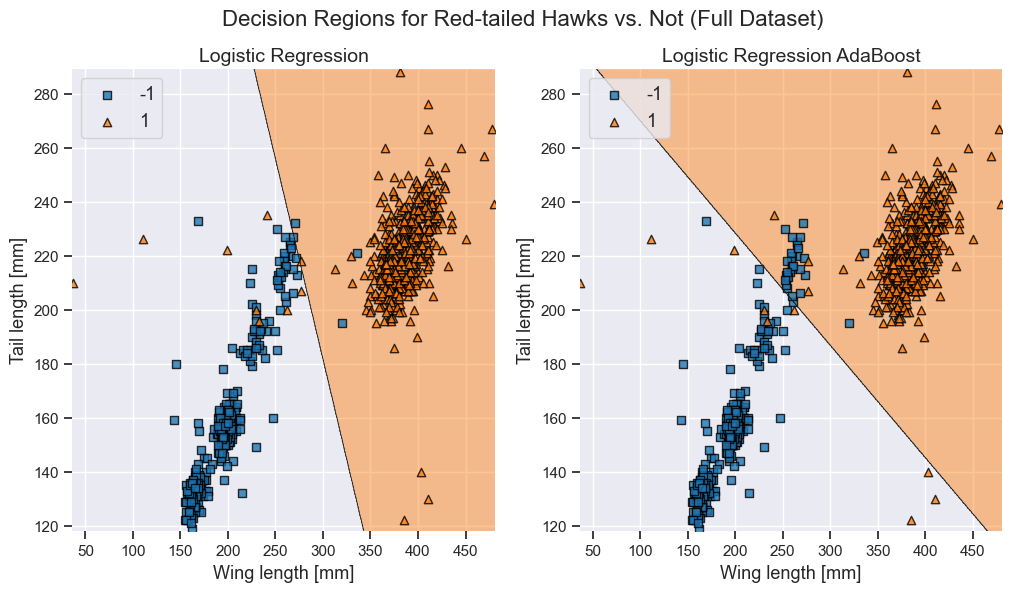

In [10]:
compare_decision_regions(X, y, log_model, ada_log,
                         clf1_title = "Logistic Regression",
                         clf2_title = "Logistic Regression AdaBoost")
plt.show()

### 1B. Decision Stump

Decision stumps, which are decision trees with a single split, are often used as the weak learners in boosting. This is because decision stumps have low complexity and can capture simple patterns in the data.

In [11]:
stump_model = DecisionTreeClassifier(max_depth = 1, random_state = 42)
stump_model.fit(X_train, y_train)
print("Training accuracy:", stump_model.score(X_train, y_train))
print("Testing accuracy:", stump_model.score(X_test, y_test))

Training accuracy: 0.9873595505617978
Testing accuracy: 0.9888268156424581


In [12]:
ada_stump = AdaBoostClassifier(stump_model, n_estimators = 10, algorithm = "SAMME.R", learning_rate = 0.5)
ada_stump.fit(X_train, y_train)
print("Training accuracy:", ada_stump.score(X_train, y_train))
print("Testing accuracy:", ada_stump.score(X_test, y_test))

ada_stump_y_pred = ada_stump.predict(X_test)
print(f"\nDecision Stump AdaBoost Classification Report")
print(classification_report(y_test, ada_stump_y_pred), "\n")

Training accuracy: 0.9873595505617978
Testing accuracy: 0.994413407821229

Decision Stump AdaBoost Classification Report
              precision    recall  f1-score   support

          -1       1.00      0.99      0.99        73
           1       0.99      1.00      1.00       106

    accuracy                           0.99       179
   macro avg       1.00      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179
 



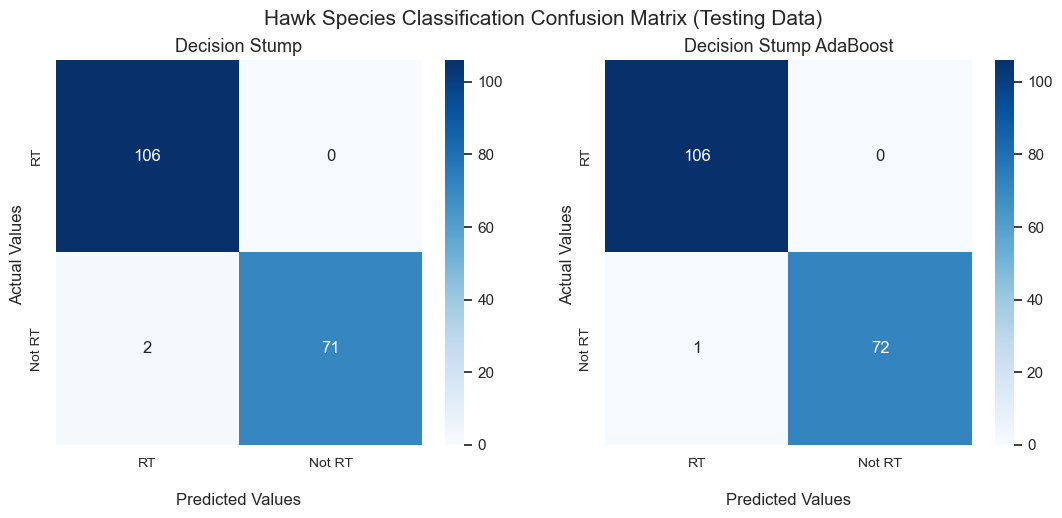

In [13]:
compare_RT_confusion_matrix(y_test, stump_model.predict(X_test), ada_stump_y_pred,
                            clf1_title = "Decision Stump",
                            clf2_title = "Decision Stump AdaBoost")
plt.suptitle("Hawk Species Classification Confusion Matrix (Testing Data)", fontsize = 15)
plt.show()

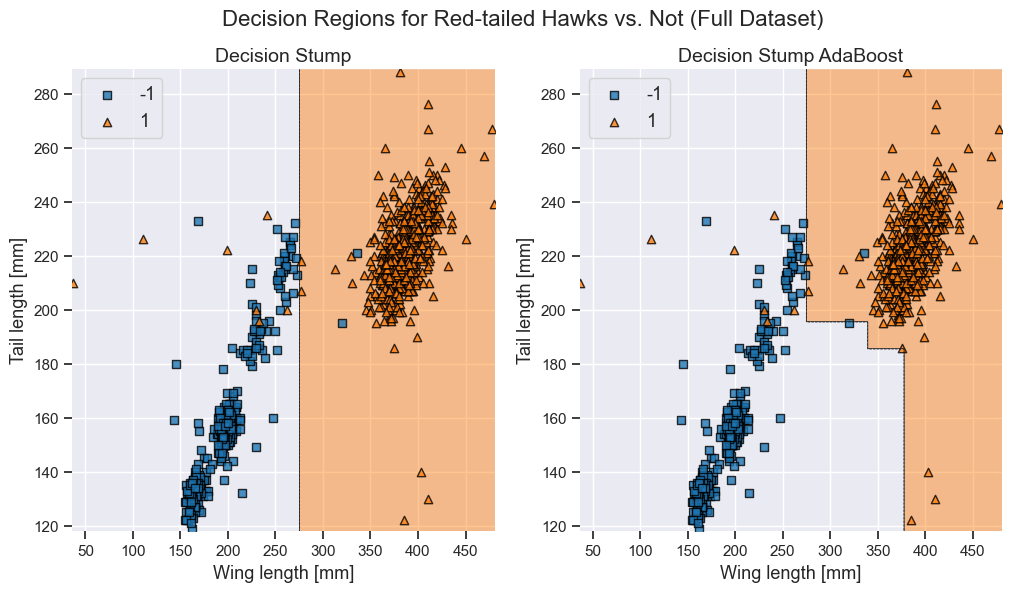

In [14]:
compare_decision_regions(X, y, stump_model, ada_stump,
                         clf1_title = "Decision Stump",
                         clf2_title = "Decision Stump AdaBoost")
plt.show()

### 1C. Decision Tree
 
Decision trees are the most commonly used base models in boosting due to their simplicity and ability to capture complex interactions between features.

In [15]:
tree_model = DecisionTreeClassifier(max_depth = 3, random_state = 42)
tree_model.fit(X_train, y_train)
print("Training accuracy:", tree_model.score(X_train, y_train))
print("Testing accuracy:", tree_model.score(X_test, y_test))

Training accuracy: 0.9929775280898876
Testing accuracy: 0.9888268156424581


In [16]:
ada_tree = AdaBoostClassifier(stump_model, n_estimators = 10, algorithm = "SAMME.R", learning_rate = 0.5)
ada_tree.fit(X_train, y_train)
print("Training accuracy:", ada_tree.score(X_train, y_train))
print("Testing accuracy:", ada_tree.score(X_test, y_test))

ada_tree_y_pred = ada_tree.predict(X_test)
print(f"\nDecision Tree AdaBoost Classification Report")
print(classification_report(y_test, ada_tree_y_pred), "\n")

Training accuracy: 0.9873595505617978
Testing accuracy: 0.994413407821229

Decision Tree AdaBoost Classification Report
              precision    recall  f1-score   support

          -1       1.00      0.99      0.99        73
           1       0.99      1.00      1.00       106

    accuracy                           0.99       179
   macro avg       1.00      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179
 



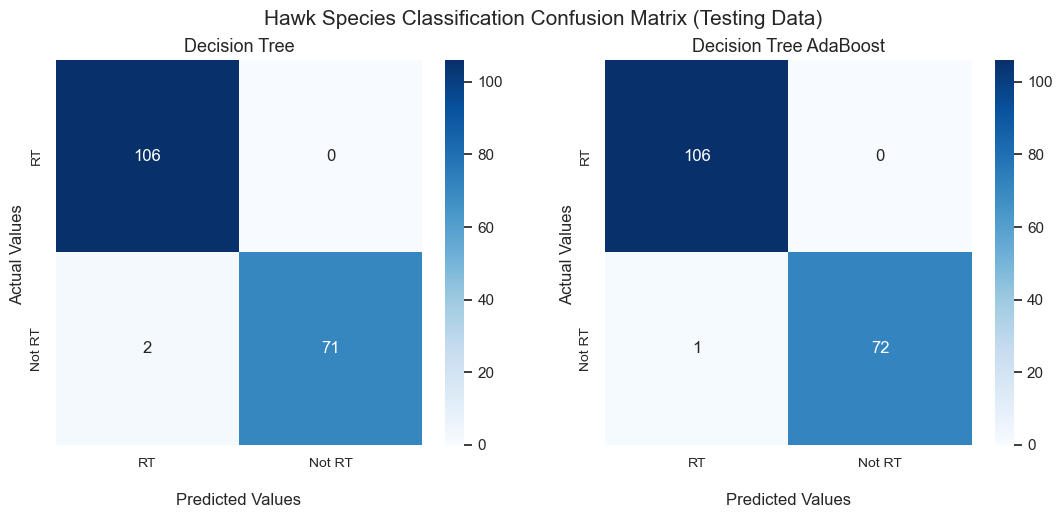

In [17]:
compare_RT_confusion_matrix(y_test, tree_model.predict(X_test), ada_tree_y_pred,
                            clf1_title = "Decision Tree",
                            clf2_title = "Decision Tree AdaBoost")
plt.suptitle("Hawk Species Classification Confusion Matrix (Testing Data)", fontsize = 15)
plt.show()

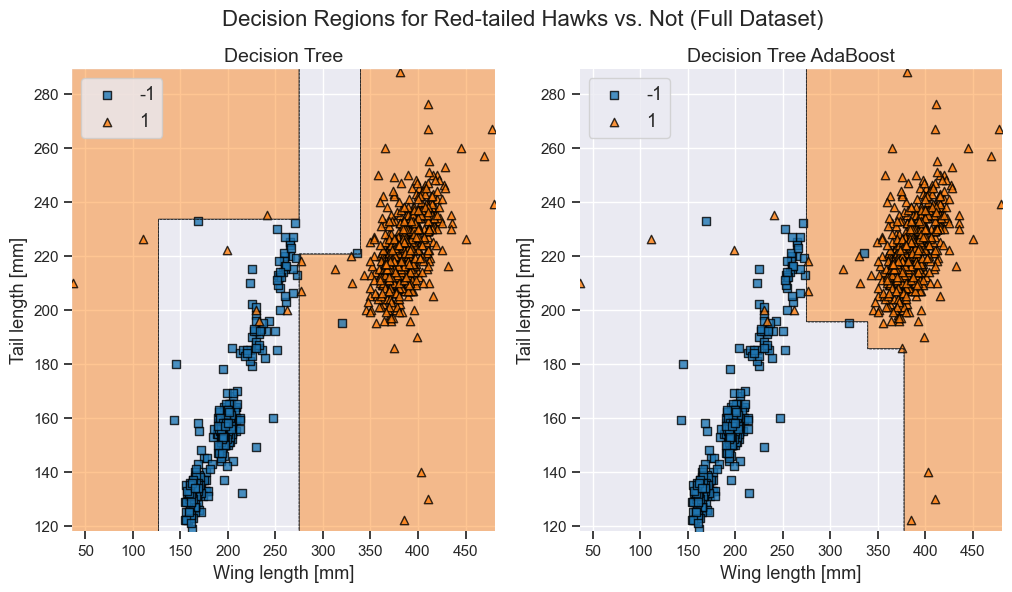

In [18]:
compare_decision_regions(X, y, tree_model, ada_tree,
                         clf1_title = "Decision Tree",
                         clf2_title = "Decision Tree AdaBoost")
plt.show()

### Further Discussion of AdaBoost Results

Based on the results of the decision stump and decision tree learners, the benefits of AdaBoost are evident.

Finally, it is worth nothing that neural networks can also be used as base models in boosting. However, due to their high complexity, neural networks are often used in combination with other weaker models to create a diverse set of base models.

## 2. Gradient Boosting

While gradient boosting can be used for both regression and classification problems, I will be using gradient boosting for the classification problem so that I can directly compare the results with what I get from AdaBoost in the previous sections.

In fitting a GradientBoostingClassifier, the user does not explicitly specify a "learner" like in AdaBoost. Instead, Gradient Boosting builds an ensemble of decision trees as the base model, where each decision tree is trained to correct the errors of the previous tree. During the training process, the algorithm fits the ensemble of decision trees by minimizing a differentiable loss function, such as mean squared error for regression or deviance for classification. The gradient of the loss function with respect to the predicted values is then used to construct the subsequent decision tree. Therefore, the goal of gradient boosting would be to improve overall performance by combining many weak decision trees; decision trees are considered to be a weak learner since they have low accuracy on their own.

In this section of the notebook, I will be running GradientBoostingClassifier for the decision stump/tree and comparing the results to what I got from AdaBoost (since I already know that the use of AdaBoost created a better predictive model than the individual decision stump/tree model on its own).

### 2A. Decision Stump

In [19]:
gb_stump = GradientBoostingClassifier(max_depth = 1, n_estimators = 10, learning_rate = 0.5)
gb_stump.fit(X_train, y_train)
print("Training accuracy:", gb_stump.score(X_train, y_train))
print("Testing accuracy:", gb_stump.score(X_test, y_test))

gb_stump_y_pred = gb_stump.predict(X_test)
print(f"\nDecision Stump Gradient Boosting Classification Report")
print(classification_report(y_test, gb_stump_y_pred), "\n")

Training accuracy: 0.9901685393258427
Testing accuracy: 0.9888268156424581

Decision Stump Gradient Boosting Classification Report
              precision    recall  f1-score   support

          -1       1.00      0.97      0.99        73
           1       0.98      1.00      0.99       106

    accuracy                           0.99       179
   macro avg       0.99      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179
 



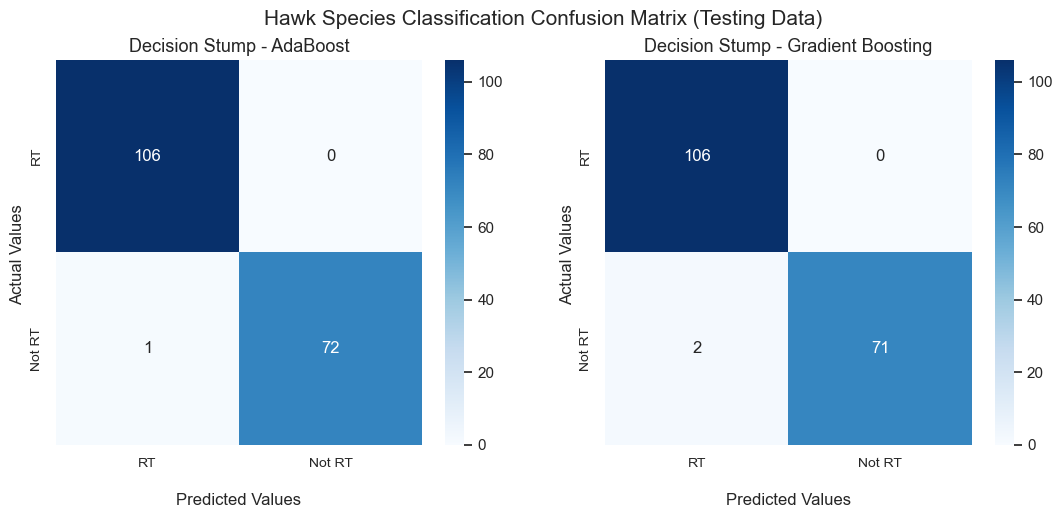

In [20]:
compare_RT_confusion_matrix(y_test, ada_stump_y_pred, gb_stump_y_pred,
                            clf1_title = "Decision Stump - AdaBoost",
                            clf2_title = "Decision Stump - Gradient Boosting")
plt.suptitle("Hawk Species Classification Confusion Matrix (Testing Data)", fontsize = 15)
plt.show()

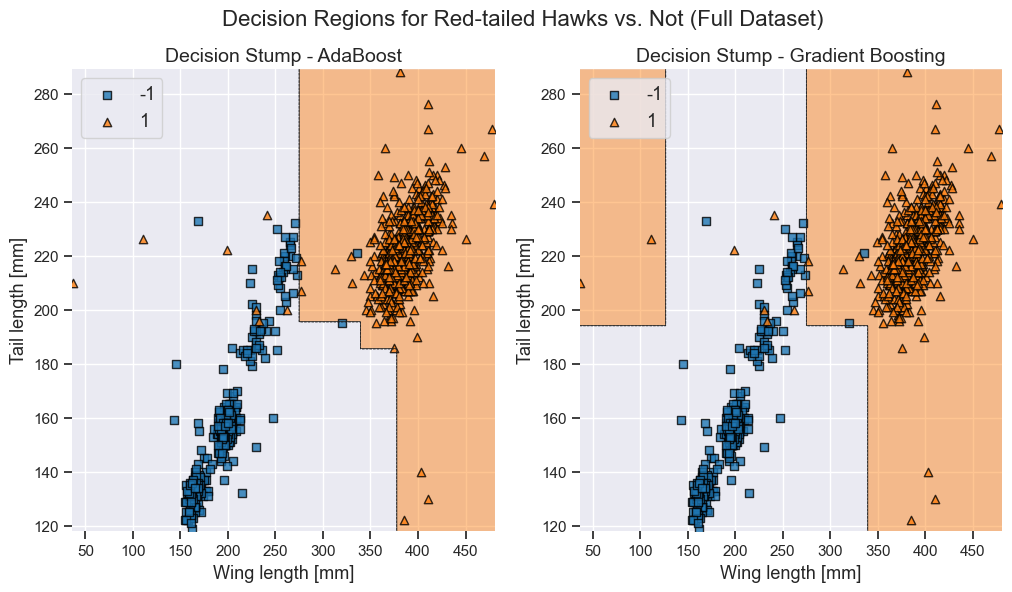

In [21]:
compare_decision_regions(X, y, ada_stump, gb_stump,
                         clf1_title = "Decision Stump - AdaBoost",
                         clf2_title = "Decision Stump - Gradient Boosting")
plt.show()

### 2B. Decision Tree

In [22]:
gb_tree = GradientBoostingClassifier(max_depth = 3, n_estimators = 10, learning_rate = 0.5)
gb_tree.fit(X_train, y_train)
print("Training accuracy:", gb_tree.score(X_train, y_train))
print("Testing accuracy:", gb_tree.score(X_test, y_test))

gb_tree_y_pred = gb_tree.predict(X_test)
print(f"\nDecision Tree Gradient Boosting Classification Report")
print(classification_report(y_test, gb_tree_y_pred), "\n")

Training accuracy: 0.9985955056179775
Testing accuracy: 0.9776536312849162

Decision Tree Gradient Boosting Classification Report
              precision    recall  f1-score   support

          -1       1.00      0.95      0.97        73
           1       0.96      1.00      0.98       106

    accuracy                           0.98       179
   macro avg       0.98      0.97      0.98       179
weighted avg       0.98      0.98      0.98       179
 



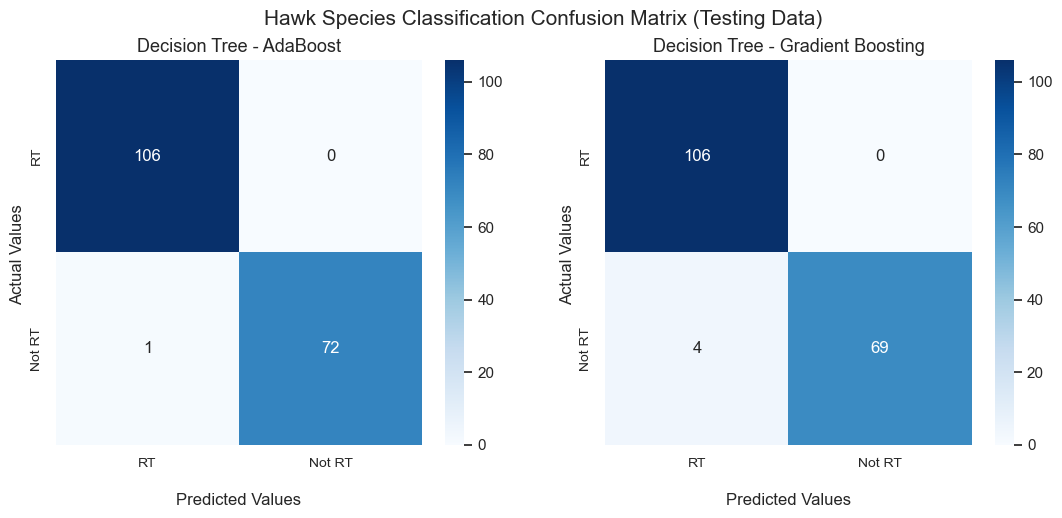

In [23]:
compare_RT_confusion_matrix(y_test, ada_tree_y_pred, gb_tree_y_pred,
                            clf1_title = "Decision Tree - AdaBoost",
                            clf2_title = "Decision Tree - Gradient Boosting")
plt.suptitle("Hawk Species Classification Confusion Matrix (Testing Data)", fontsize = 15)
plt.show()

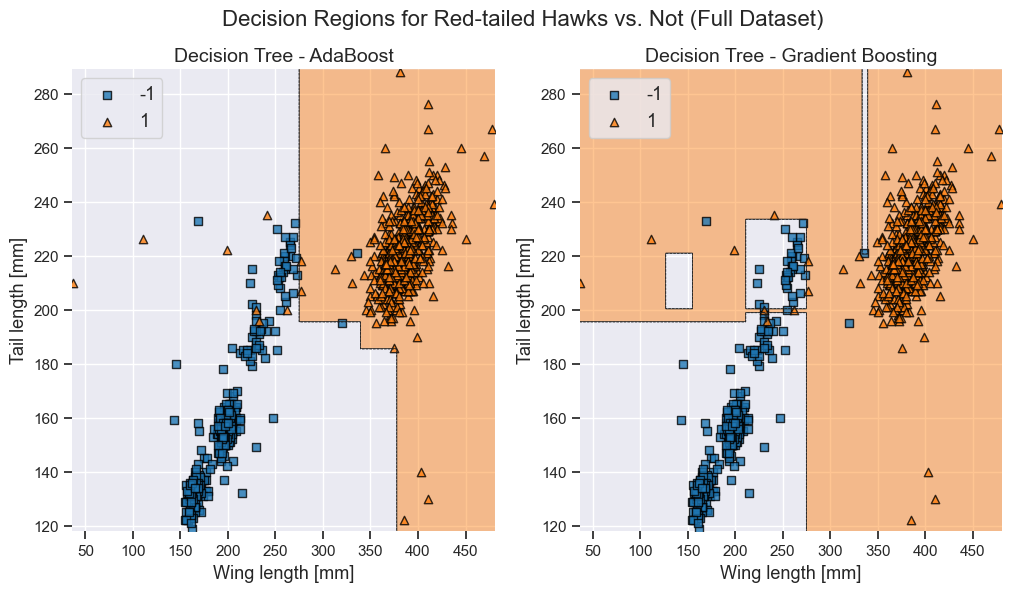

In [24]:
compare_decision_regions(X, y, ada_tree, gb_tree,
                         clf1_title = "Decision Tree - AdaBoost",
                         clf2_title = "Decision Tree - Gradient Boosting")
plt.show()

For both the decision stump and tree, AdaBoost resulted in the better classifier with higher predictive accuracy, while also being less prone to overfitting. I will finish off my analysis of boosting by summarizing the results in this notebook in the Discussion/Conclusions section below, with some reasons why.

## Discussion/Conclusions

One advantage of AdaBoost is that it is less prone to overfitting than Gradient Boosting, especially when the base models are shallow and simple. Additionally, AdaBoost can work well with a variety of base models, not just decision trees. On the other hand, AdaBoost can be sensitive to noisy data and outliers, and it can be computationally expensive to train when dealing with large datasets.

Gradient Boosting, on the other hand, is known for its high predictive accuracy and is often the go-to algorithm for many machine learning problems. It is also more robust to noisy data and can handle larger datasets more efficiently than AdaBoost. However, Gradient Boosting can be more prone to overfitting, especially when the base models are deep and complex, and it can be more difficult to tune than AdaBoost.